# MITGCM Scale Analysis 

**Purpose**: Code for preforming the spatial scale analysis. I will be preformed this analysis on zonal and meridional spatial transects on, off, and in the transition region of the shelf. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from scipy.interpolate import interp1d
from geopy.distance import geodesic

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + "AirSeaCoupling/tools/")

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from lsf import unweighted_lsf

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density

# Set time and space parameters
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function   
lon_point = -122 % 360                       # Specifies the longitude point of the time record 
lat_point = 34.25                               # Specifies the latitude point of the time record 
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/' #"/data/SO3/lcolosi/mitgcm/SWOT_MARA_RUN4_LY/"
PATH_figs = ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 16

Load mitgcm data netcdf files 

In [4]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "THETA_CCS4_hrly_ts_ext.nc"
elif option_var == 'sal':
    filename = PATH + "SALT_CCS4_hrly_ts_ext.nc"
elif option_var == 'density':
    filename = PATH + "RHO_CCS4_hrly_ts_ext.nc"
nc = Dataset(filename, 'r')

# Extract data variables
water_depth   = nc.variables['Depth'][:]

lon = nc.variables['XC'][:]
lat = nc.variables['YC'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

if option_var == 'temp':
    data = nc.variables['THETA'][:]
elif option_var == 'sal':
    data = nc.variables['SALT'][:]
elif option_var == 'density':
    data = nc.variables['RHO'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Remove the time mean and seasonal cycle from each grid point

In [5]:
# Set parameters
ntime,nlat,nlon = np.shape(data)
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/hr

# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Initialize array
data_r = np.zeros((ntime,nlat,nlon))

# Loop through longitude
for ilon in range(0,nlon-1): 

    # Set progress bar
    progress = (ilon + 1) / (nlon-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Loop through latitude
    for ilat in range(0,nlat-1): 

        # Initialize the ith time series 
        data_ts = data[:,ilat,ilon]

        # Remove time mean and annual and semi-annual cycles 
        hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
        data_r[:,ilat,ilon] = data_ts - hfit


Progress: 100.0%

Obtain the zonal and meridional sections

In [6]:
# Find the spatial indices of the longitude and latitude point
idx_m = np.argmin(np.abs(lon - lon_point))
idx_z = np.argmin(np.abs(lat - lat_point))

# Extract data 
data_z = data_r[:,idx_z,:]
data_m = data_r[:,:,idx_m] 

Read in bathymetry data

In [7]:
# Load bathymetry data 
filename = PATH_bathy + "topo_25.1.nc"
ds_bathy = xr.open_dataset(filename, engine="netcdf4")

# Extract data variables
lon_b = ds_bathy["lon"]  # Longitude
lat_b = ds_bathy["lat"]  # Latitude
bathy = ds_bathy["z"]    # Elevation/Bathymetry

# Convert convesion of longitude (neg from the prime meridian to positive definite wrapping around the earth)
lon_n = lon_b % 360

# Set max and min values 
lon_min = lon_bnds[0]
lon_max = lon_bnds[1]
lat_min = lat_bnds[0]
lat_max = lat_bnds[1]

# Extract data from bathymetry 
lon_grid = lon_n[(lon_n >= lon_min) & (lon_n <= lon_max)]
lat_grid = lat_b[(lat_b >= lat_min) & (lat_b <= lat_max)]
bathy_grid   = bathy[(lat_b >= lat_min) & (lat_b <= lat_max),(lon_n >= lon_min) & (lon_n <= lon_max)]

Plot the spatial domain

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_53225/3590406459.py:79: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(lon_point*np.ones((len(lat),)), lat, '-', transform=ccrs.PlateCarree(),
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_53225/3590406459.py:82: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(lon, lat_point*np.ones((len(lon),)), '-', transform=ccrs.PlateCarree(),


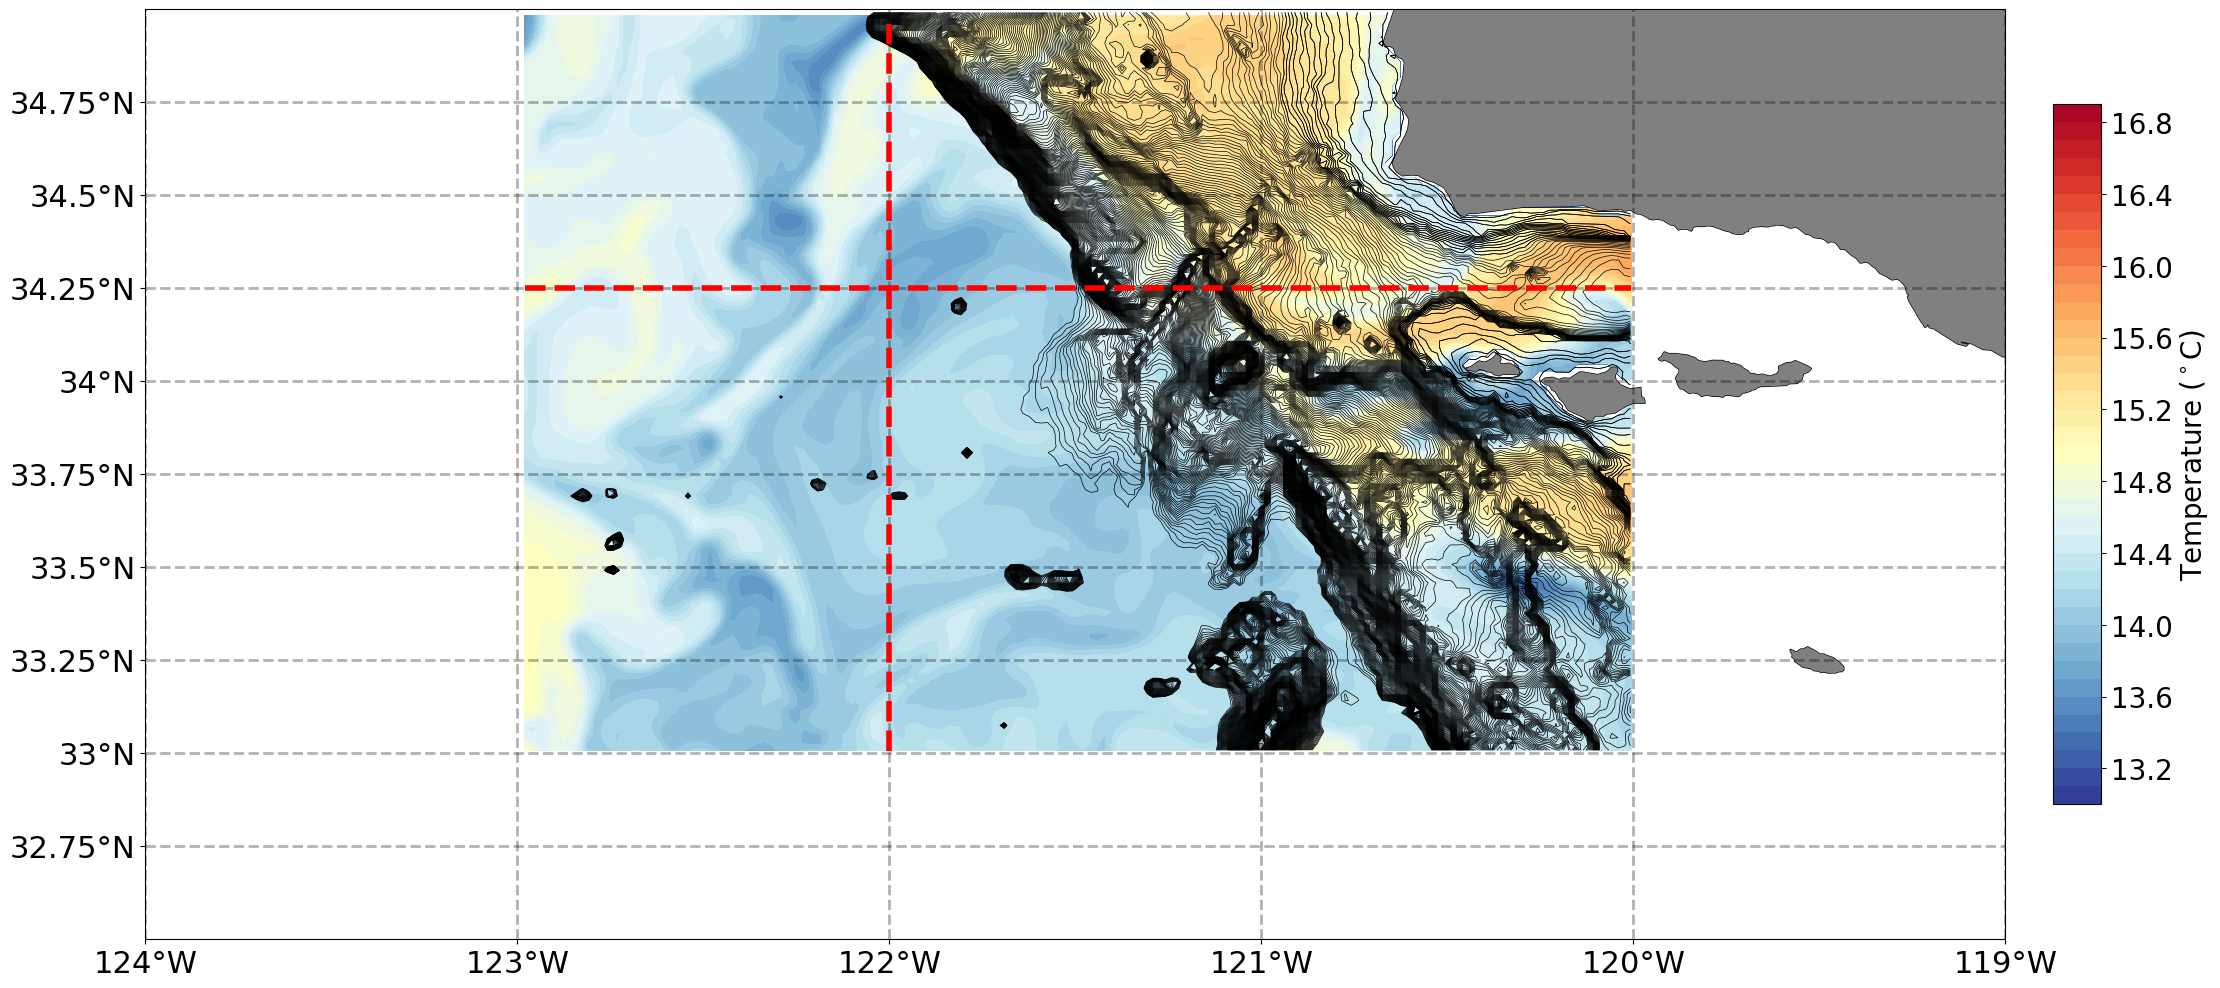

In [21]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-124, -123, -122, -121, -120, -119]
yticks = [32.75, 33.00, 33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75,]
resolution = "10m"
bounds = np.arange(0,360+40,40)
lon_min = -124
lon_max = -119
lat_min = 32.50
lat_max = 35

# Specify data specific attributes 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    label = r'Temperature ($^\circ$C)'
    levels = np.arange(13,17,0.1)
elif option_var == 'sal':
    cmap = 'BrBG_r'
    label = r'Salinity (psu)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    cmap = 'Spectral_r'
    label = r'$\sigma_0$ (kg m$^{-3}$)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Create figure
fig, axes = plt.subplots(1,1, figsize=(24, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=-124, lon_max=-119, lat_min=32.50, lat_max=35) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, data[1,:,:], levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmap,  
    shading="auto"
)

# Plot depth contour lines
levels_bath_coast = np.arange(-300,0,20)
levels_bath_open = np.arange(-3500,0,20)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath_coast, colors='black', linewidths=0.5, linestyles='solid')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath_open, colors='black', linewidths=0.5, linestyles='solid')
#contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
#plt.clabel(contour1, fontsize=14)
#plt.clabel(contour2, fontsize=14)
#plt.clabel(contour3, fontsize=14)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=label,
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Plot the 
axes.plot(lon_point*np.ones((len(lat),)), lat, '-', transform=ccrs.PlateCarree(), 
          color='red', linestyle='dashed',linewidth=4)

axes.plot(lon, lat_point*np.ones((len(lon),)), '-', transform=ccrs.PlateCarree(), 
          color='red', linestyle='dashed',linewidth=4)

# Show the plot
plt.show()

Plot the hovmuller plot

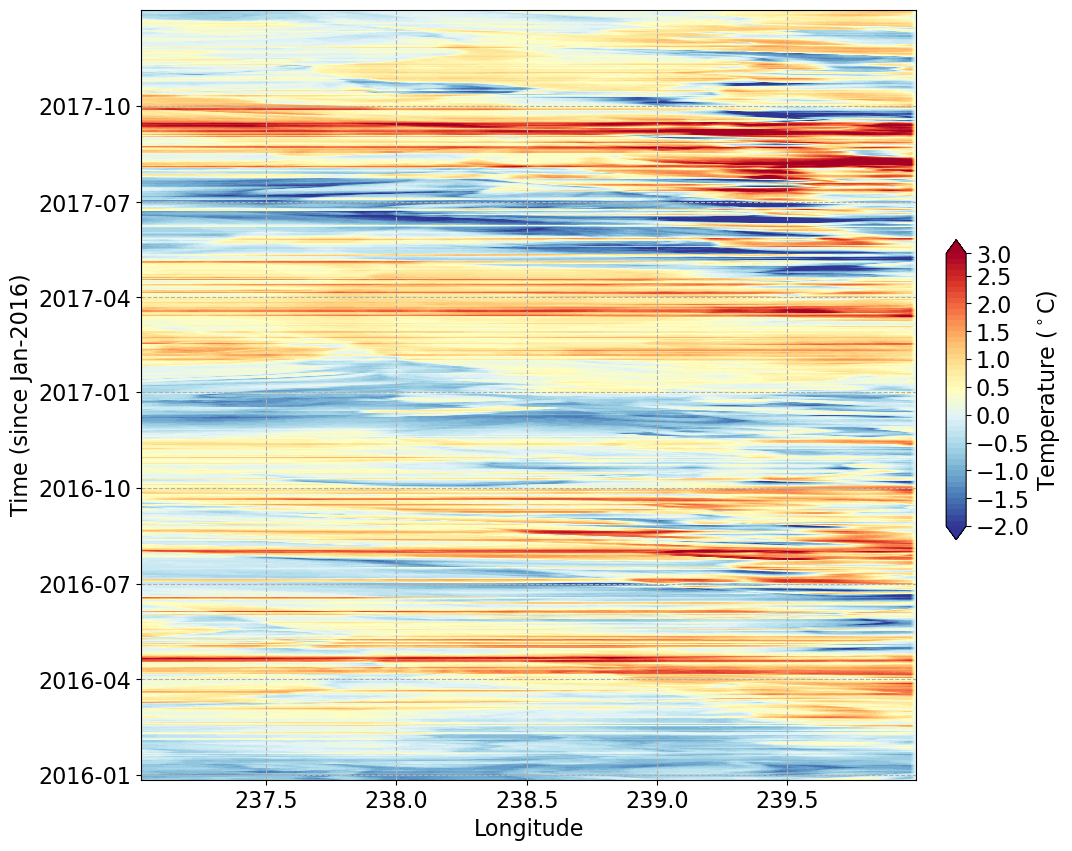

In [9]:
# Specify data specific attributes 
if option_var == 'temp':
    levels = np.arange(-2,3,0.1)
elif option_var == 'sal':
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure
fig, axes = plt.subplots(1,1, figsize=(10, 10))

# Plot zonal temperature
ctf = axes.contourf(lon,time_dt,data_z,cmap='RdYlBu_r',levels=levels,extend='both')

# Create colorbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    ctf,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=label,
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set the figure attributes 
axes.set_xlabel('Longitude')
axes.set_ylabel('Time (since Jan-2016)')
#axes.set_ylim([time_dt[0], time_dt[8000]])
axes.grid(True, linestyle='--')
plt.show()

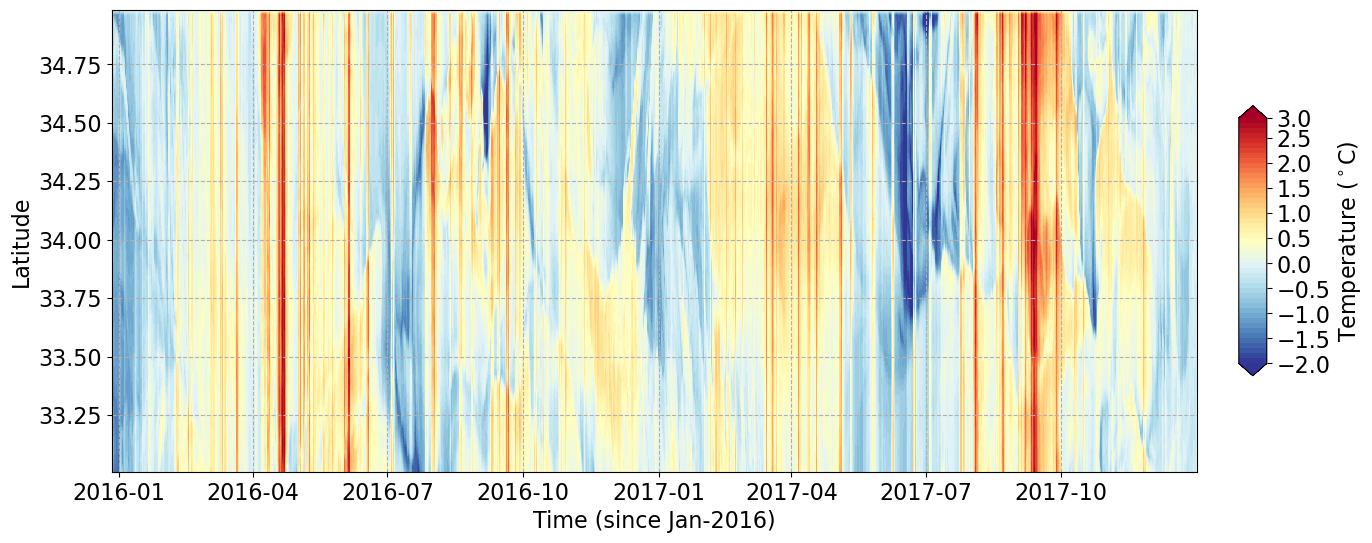

In [10]:
# Create figure
fig, axes = plt.subplots(1,1, figsize=(14, 6))

# Plot zonal temperature
ctf = axes.contourf(time_dt,lat,data_m.T,cmap='RdYlBu_r',levels=levels,extend='both')

# Create colorbar
cax = plt.axes([0.93, 0.27, 0.02, 0.45])
cart.set_cbar(
    ctf,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=label,
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set the figure attributes 
axes.set_xlabel('Time (since Jan-2016)')
axes.set_ylabel('Latitude')
# axes.set_xlim([time_dt[0], time_dt[1000]])
axes.grid(True, linestyle='--')
plt.show()

Compute the zonal and meridional distances 

In [11]:
#--- Meridional ---# 

# Set the latitude and longutiude coordinates starting points
lon_st_m, lat_st_m = lon_point, lat[0]
point_st = (lat_st_m,lon_st_m)

# Set the dimension of the latitude and longitude vectors 
nlat = len(lat)
nlon = len(lon)

# Initialize masked array
dist_m = np.zeros([nlat,])

# Loop through latitude steps 
for idata in range(0,nlat):

        # Generate coordinate pair 
        point_g = (lat[idata],lon_st_m)

        # Compute the distance from the shore relative to Point Conception 
        dist_m[idata] = geodesic(point_g, point_st).kilometers

# Compute the mean distance between points
dr_m = np.mean(np.diff(dist_m))

#--- Zonal ---# 

# Set the latitude and longutiude starting points
lon_st_z, lat_st_z = lon[0], lat_point
point_st = (lat_st_z,lon_st_z)

# Set the dimension of the latitude and longitude vectors 
nlat = len(lat)
nlon = len(lon)

# Initialize masked array
dist_z = np.zeros([nlon,])

# Loop through latitude steps 
for idata in range(0,nlon):

        # Generate coordinate pair 
        point_g = (lat_st_z,lon[idata])

        # Compute the distance from the shore relative to Point Conception 
        dist_z[idata] = geodesic(point_g, point_st).kilometers

# Compute the mean distance between points
dr_z = np.mean(np.diff(dist_z))

Preform the scale analysis

In [12]:
# Set parameters
ntime = len(time)
lag_m = np.shape(data_m)[1]
lag_z = np.shape(data_z)[1]
incr = 12
ntime_s = int(np.ceil(ntime/incr))
    
# Convert to seconds since start time
t0 = time_dt[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time_dt])

# Convert data into a masked array
mask_z = np.zeros_like(data_z, dtype=bool)
mask_m = np.zeros_like(data_m, dtype=bool)
data_zm = np.ma.masked_array(data_z, mask=mask_z)
data_mm = np.ma.masked_array(data_m, mask=mask_m)

#--- Meridional ---# 

# Initialize arrays 
autocorr_m = np.zeros((ntime_s,lag_m))
length_scale_m = np.zeros((ntime_s,lag_m))
L_m = np.zeros((ntime_s,))
cn_time = 0 

# Print Statement
print('Meridional')
print('----------')

# Loop through time
for itime in range(0,ntime-1,incr):

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Initialize the ith meridional spatial record  
    data_ts = data_mm[itime,:]

    # Compute autocorrelation function
    autocorr_m[cn_time,:], _, _, _, length_scale_m[cn_time,:], _ = compute_autocorr(data_ts, dist_m, lag_m, estimator, 0)

    # Compute the decorrelation scale
    L_m[cn_time] = compute_decor_scale(autocorr_m[cn_time,:],length_scale_m[cn_time,:],dr_m,estimator,0)

    # Set longitude counter
    cn_time = cn_time + 1

#--- Zonal ---# 

# Initialize arrays 
autocorr_z = np.zeros((ntime_s,lag_z))
length_scale_z = np.zeros((ntime_s,lag_z))
L_z = np.zeros((ntime_s,))
cn_time = 0 

# Print Statement
print('Zonal')
print('----------')

# Loop through time
for itime in range(0,ntime-1,incr):

    # Set progress bar
    progress = (itime + 1) / (len(time)-1)
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()

    # Initialize the ith meridional spatial record  
    data_ts = data_zm[itime,:]

    # Compute autocorrelation function
    autocorr_z[cn_time,:], _, _, _, length_scale_z[cn_time,:], _ = compute_autocorr(data_ts, dist_z, lag_z, estimator, 0)

    # Compute the decorrelation scale
    L_z[cn_time] = compute_decor_scale(autocorr_z[cn_time,:],length_scale_z[cn_time,:],dr_z,estimator,0)

    # Set longitude counter
    cn_time = cn_time + 1


Progress: 0.0%

Progress: 100.0%

Plot the Decorrelation scale as a function of time

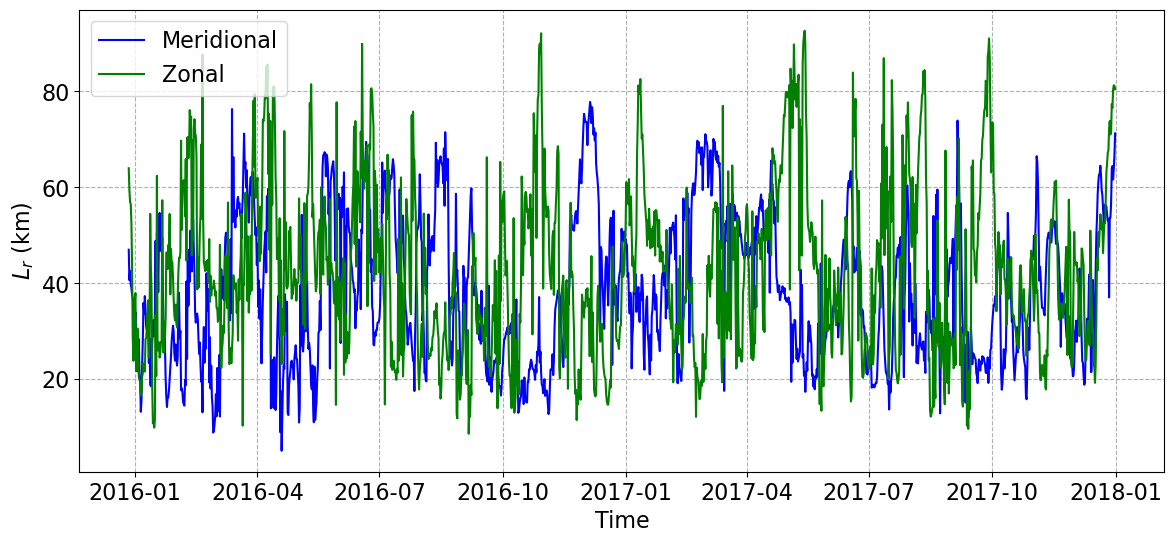

In [19]:
# Set the time vector 
time_s = time_dt[:-1:incr]

# Create figure
fig, axes = plt.subplots(1,1, figsize=(14, 6))

# Plot length decorrelation scale 
axes.plot(time_s,L_m,'-b', label='Meridional')
axes.plot(time_s,L_z,'-g', label='Zonal')
axes.set_xlabel('Time')
axes.set_ylabel(r'$L_r$ (km)')
axes.legend()
axes.grid(True, linestyle='--')
plt.show()